In [5]:
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, steps = get_model_for_problem_formulation(2)

reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "discount rate 0": 3.5,
    "discount rate 1": 3.5,
    "discount rate 2": 3.5,
    "ID flood wave shape": 4,
}
scen1 = {}


# Searching for candidate solutions

In [7]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)


for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

convergence_metrics = [
    ArchiveLogger(
        "./archives",
        [l.name for l in dike_model.levers],
        [o.name for o in dike_model.outcomes],
        base_filename="MOEA_archive.tar.gz",
    ),
    EpsilonProgress()
]

epsilon = [1e3] * len(dike_model.outcomes)

nfe = 500  # 200 is proof of principle only, way to low for actual use

In [8]:
with MultiprocessingEvaluator(dike_model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=epsilon,
            convergence=convergence_metrics,
            reference=ref_scenario,
        )

[MainProcess/INFO] pool started with 12 workers
598it [00:57, 10.35it/s]                                                       
[MainProcess/INFO] optimization completed, found 27 solutions
[MainProcess/INFO] terminating pool


In [9]:
with open(r'generated_datasets\MOEA_results.pkl','wb') as pickle_file:
    pickle.dump(results, pickle_file)

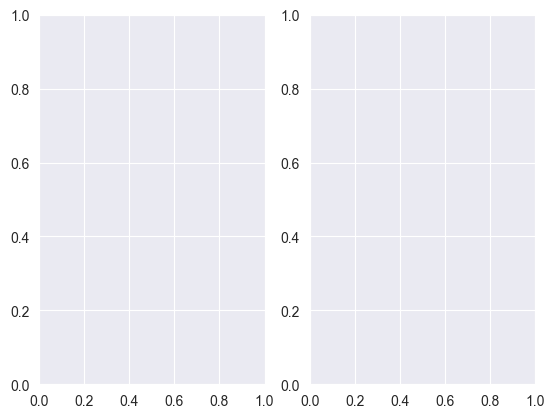

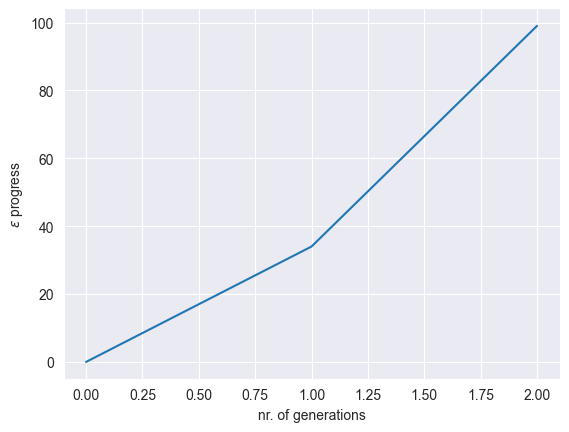

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel("nr. of generations")
ax1.set_ylabel(r"$\epsilon$ progress")
sns.despine()

[]

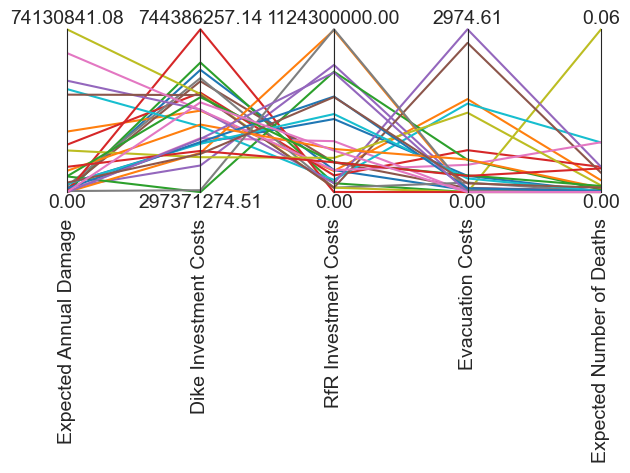

In [11]:
from ema_workbench.analysis import parcoords

outcomes = results.loc[:, list(dike_model.outcomes.keys())]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same
# axes.invert_axis('max_P')
plt.plot()

In [12]:
import pandas as pd
df = pd.read_pickle(r'generated_datasets\MOEA_results.pkl')
df

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,0,0,0,0,0,1,0,0,0,...,2,4,6,5,5,5.478577e+05,6.330335e+08,1.519000e+08,34.579280,0.000057
1,0,0,1,0,0,0,1,1,0,0,...,4,1,1,9,5,2.755751e+07,5.210095e+08,1.460000e+08,1699.023743,0.004586
2,0,0,0,0,0,0,1,1,0,0,...,6,7,9,2,6,0.000000e+00,6.531481e+08,6.140000e+07,0.000000,0.000000
3,1,0,0,0,0,0,1,0,0,0,...,6,4,2,1,3,2.155737e+07,5.703469e+08,1.153000e+08,765.961542,0.009838
4,1,0,1,1,1,0,1,0,0,0,...,3,0,1,1,0,2.118914e+06,3.704782e+08,8.779000e+08,73.677264,0.000766
5,0,1,0,0,0,0,0,0,0,1,...,2,1,6,6,4,1.396476e+06,6.018311e+08,2.058000e+08,73.761478,0.000376
6,0,1,1,0,0,0,0,1,1,1,...,5,1,8,5,3,0.000000e+00,4.454774e+08,3.518000e+08,0.000000,0.000000
7,0,0,0,0,0,0,1,0,0,0,...,6,5,5,0,6,2.694706e+06,6.105322e+08,3.070000e+07,173.764641,0.000273
8,0,0,0,0,0,0,1,0,0,0,...,5,1,5,1,9,7.413084e+07,5.666531e+08,3.070000e+07,0.000000,0.063559
9,1,0,0,0,0,0,0,0,0,0,...,6,4,1,1,0,4.692290e+07,4.778188e+08,8.460000e+07,1616.674656,0.019357


### Test met random en archivelogger

In [13]:
import random

random.seed(20)

In [14]:
convergence_metrics = [
    ArchiveLogger(
        "./archives",
        [l.name for l in dike_model.levers],
        [o.name for o in dike_model.outcomes],
        base_filename="MOEA_archive.tar.gz",
    ),
    EpsilonProgress()
]

with MultiprocessingEvaluator(dike_model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=epsilon,
            convergence=convergence_metrics,
            reference=ref_scenario,
        )

[MainProcess/INFO] pool started with 12 workers
599it [01:02,  9.55it/s]                                                       
[MainProcess/INFO] optimization completed, found 34 solutions
[MainProcess/INFO] terminating pool


In [16]:
archives = ArchiveLogger.load_archives("./archives/MOEA_archive.tar.gz")

In [17]:
from ema_workbench import HypervolumeMetric
from ema_workbench.em_framework.optimization import to_problem
import numpy as np

reference_set = results
problem = to_problem(dike_model, searchover="levers")

hv = HypervolumeMetric(reference_set, problem)

hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

AttributeError: 'Pandas' object has no attribute '0_RfR 0'

NameError: name 'hypervolume' is not defined

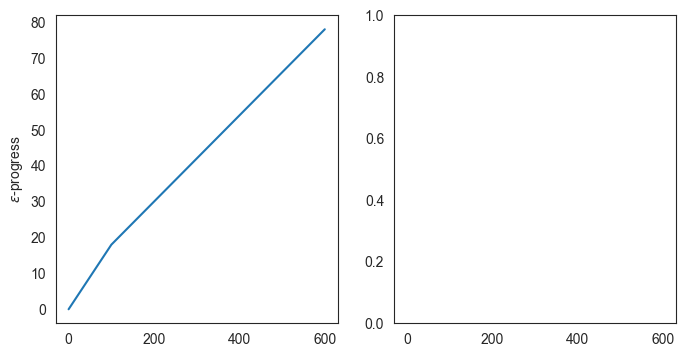

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()